In [3]:
%pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 5.0 MB/s eta 0:00:00


In [7]:
# Initialize the Reddit instance
import praw
from datetime import datetime, timedelta

reddit = praw.Reddit(
    client_id='2-nK08fwsk8dv1FncBaaNw',
    client_secret='NWPQ36rCKKCOQwuguJfBuPrB86WXqQ',
    user_agent='CryptoSentimentAnalyzer by /u/Advanced-Maybe-8341',
    check_for_async=False
)

# Example of fetching the top posts from a subreddit
submissions = reddit.subreddit('finance').top(limit=5)
for submission in submissions:
    print(f"Title: {submission.title}")
    print(f"Score: {submission.score}")
    print(f"URL: {submission.url}")
    print("="*40)
# Define subreddits
subreddits = ['cryptocurrency']

# Define bull and bear sentiment keywords
bull_keywords = ['bull', 'bullish', 'moon', 'lambo', 'hodl', 'buy', 'long', 'uptrend', 'breakout', 'rally']
bear_keywords = ['bear', 'bearish', 'crash', 'dip', 'sell', 'short', 'downtrend', 'correction', 'dump', 'fud']

# Function to get comments from a subreddit
def get_comments(subreddit_name, start_date):
    subreddit = reddit.subreddit(subreddit_name)
    comments = []
    for submission in subreddit.new(limit=None):
        if submission.created_utc < start_date:
            break
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            comments.append({
                'text': comment.body,
                'created_utc': datetime.fromtimestamp(comment.created_utc),
                'subreddit': subreddit_name
            })
    return comments

# Get comments from the last month
end_date = datetime.now()
start_date = end_date - timedelta(days=30)
all_comments = []

for subreddit in subreddits:
    all_comments.extend(get_comments(subreddit, start_date.timestamp()))

Title: Bipartisan bill would ban lawmakers from buying, selling stocks
Score: 11987
URL: https://thehill.com/policy/finance/541425-bipartisan-bill-would-ban-lawmakers-from-buying-selling-stocks
Title: Wall st short-sellers lost $1.6 billion in a single day as Reddit traders rebelled against them
Score: 7786
URL: https://markets.businessinsider.com/news/stocks/gamestop-stock-short-seller-squeeze-losses-reddit-traders-citron-gme-2021-1-1030000080
Title: Donald Trump Plans 10% Tariffs on China Goods, 25% on Mexico and Canada
Score: 6800
URL: https://www.bloomberg.com/news/articles/2024-11-25/trump-plans-10-tariffs-on-china-goods-25-on-mexico-and-canada
Title: Robinhood, Interactive Brokers restrict trading in GameStop stock and options
Score: 6024
URL: https://www.cnbc.com/2021/01/28/robinhood-interactive-brokers-restrict-trading-in-gamestop-s.html
Title: The US is considering a sovereign wealth fund. Alaska already has one, and it's funding a universal basic income.
Score: 5448
URL: http

In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

# Download the VADER lexicon
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
# Preparing the dataset for visualization
import pandas as pd

text_df = pd.DataFrame(all_comments) # Create a DataFrame from the comments

text_df['tokenized'] = text_df['text'].apply(word_tokenize) # Tokenize the comments
text_df['tokenized'] = text_df['tokenized'].apply(lambda x: [word.lower() for word in x]) # Convert words to lowercase

text_df['bull_count'] = text_df['tokenized'].apply(lambda x: sum(1 for word in x if word in bull_keywords)) # Count bull keywords
text_df['bear_count'] = text_df['tokenized'].apply(lambda x: sum(1 for word in x if word in bear_keywords)) # Count bear keywords

text_df['sia'] = text_df['text'].apply(lambda x: sia.polarity_scores(x)['compound']) # Calculate sentiment using NLTK

text_df.set_index('created_utc', inplace=True) # Set the index to the created_utc column
text_df.sort_index(inplace=True) # Sort the DataFrame by the index

In [14]:
# Downloading BTCUSD price as a cryptomarket proxy.
import yfinance as yf
btcusd = yf.download('BTC-USD', start=start_date, end=end_date)['Close'] # Download Bitcoin price data

/tmp/ipython-input-14-1857640027.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btcusd = yf.download('BTC-USD', start=start_date, end=end_date)['Close'] # Download Bitcoin price data
[*********************100%***********************]  1 of 1 completed


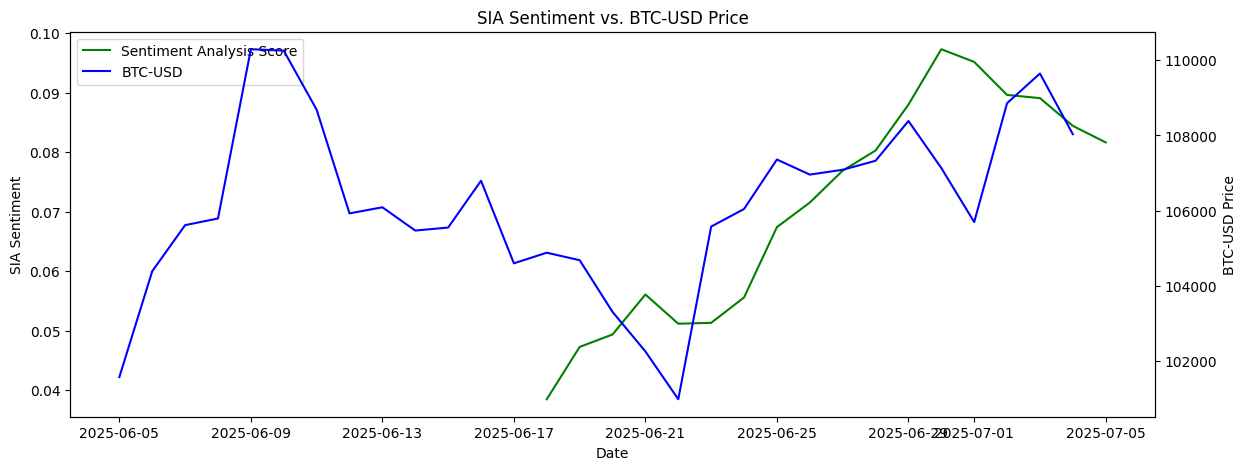

In [16]:
# Superimposing the price on the smoothened sentiment score
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 5)) # Create a figure and axis
ax2 = ax1.twinx() # Create a second axis that shares the same x-axis

smoothened_sia = text_df[['sia']].resample('D').mean().rolling('7D').mean() # Calculate the rolling mean of SIA
ax1.plot(smoothened_sia, color='green', label='Sentiment Analysis Score') # Plot the SIA mean
ax2.plot(btcusd, color='blue', label='BTC-USD') # Plot the Bitcoin price

ax1.set_ylabel('SIA Sentiment') # Set the label for the first axis
ax2.set_ylabel('BTC-USD Price') # Set the label for the second axis
ax1.set_xlabel('Date') # Set the label for the x-axis

# Get the handles and labels from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Combine the handles and labels, and create a legend
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('SIA Sentiment vs. BTC-USD Price') # Set the title of the plot
plt.show() # Show the plot

In [17]:
keywords_bull_bear = text_df[['bull_count', 'bear_count']].resample('D').sum()
bull_minus_bear = keywords_bull_bear['bull_count'] - keywords_bull_bear['bear_count']
bull_minus_bear = bull_minus_bear.rolling('7D').mean()

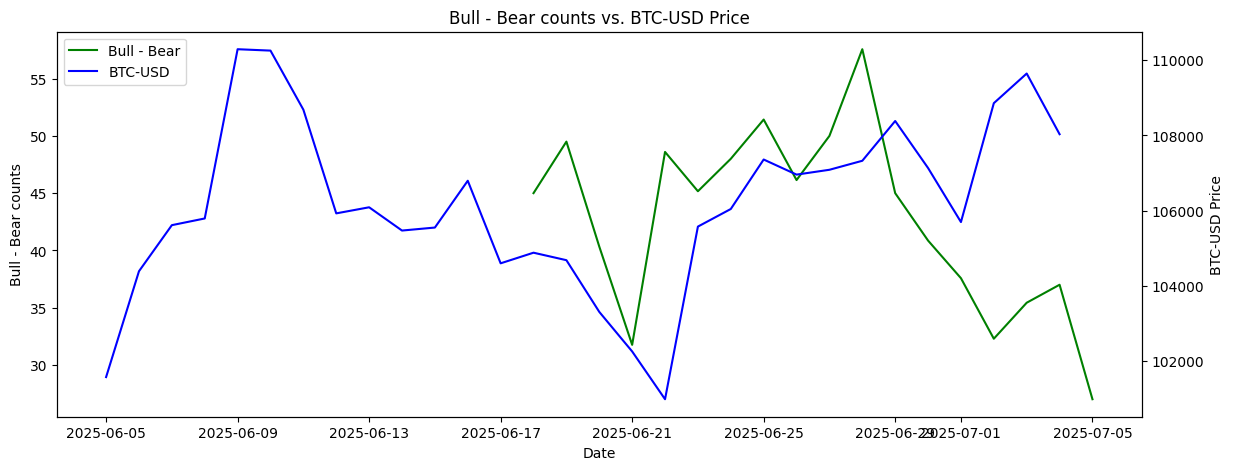

In [18]:
fig, ax1 = plt.subplots(figsize=(14, 5)) # Create a figure and axis
ax2 = ax1.twinx() # Create a second axis that shares the same x-axis


ax1.plot(bull_minus_bear, color='green', label='Bull - Bear') # Plot the difference
ax2.plot(btcusd, color='blue', label='BTC-USD') # Plot the Bitcoin price

ax1.set_ylabel('Bull - Bear counts') # Set the label for the first axis
ax2.set_ylabel('BTC-USD Price') # Set the label for the second axis
ax1.set_xlabel('Date') # Set the label for the x-axis

# Get the handles and labels from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Combine the handles and labels, and create a legend
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Bull - Bear counts vs. BTC-USD Price') # Set the title of the plot
plt.show() # Show the plot